In [1]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
sys.path.append(project_root)  

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from ms.handler.data_source import TabzillaSource
from ms.metaresearch.meta_model import MetaModel
from ms.metaresearch.selectors.base import *
from ms.metaresearch.selectors.causal import *
from ms.metaresearch.selectors.model_based import *
from ms.metaresearch.selectors.model_free import *
from ms.metaresearch.selectors.model_wrapper import *
import random

from ms.metadataset.metadata_sampler import DataSampler
from ms.metaresearch.meta_learning import MetaLearner
from ms.metaresearch.plotting import Plotter
import matplotlib.pyplot as plt
import shap
import seaborn as sns

c:\Users\Irina\anaconda3\envs\synth_shift\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
X = pd.read_csv('../resources/tabzilla/preprocessed/features__power.csv')
X = X.drop(columns=['dataset_name'])
X

,f__pymfe.statistical.nr_disc,f__pymfe.landmarking.linear_discr.mean,f__pymfe.model-based.leaves_per_class.min,f__pymfe.landmarking.linear_discr.max,f__pymfe.landmarking.worst_node.min,f__pymfe.model-based.leaves_per_class.max,f__pymfe.landmarking.elite_nn.max,f__pymfe.landmarking.elite_nn.mean,f__pymfe.model-based.var_importance.mean,f__pymfe.landmarking.worst_node.mean,...,f__pymfe.statistical.t_mean.min,f__pymfe.info-theory.class_ent,f__pymfe.landmarking.one_nn.skewness,f__pymfe.landmarking.linear_discr.kurtosis,f__pymfe.landmarking.one_nn.kurtosis,f__pymfe.landmarking.elite_nn.kurtosis,f__pymfe.landmarking.random_node.skewness,f__pymfe.general.nr_bin,f__pymfe.general.freq_class.skewness,f__pymfe.statistical.sparsity.skewness
0,-0.717694,-0.058807,0.300973,-0.079564,0.377100,0.325937,-0.032274,0.000554,-0.346265,0.354576,...,0.001745,-1.809913,-0.060385,-0.054699,0.011987,0.056088,0.045381,-0.853296,-0.191565,0.002694
1,-0.717694,0.331661,1.057782,0.367881,0.740437,0.434462,0.826934,1.012217,0.851732,1.047139,...,0.016592,-0.357676,1.098362,-1.021351,-0.555947,0.855549,0.123710,1.242876,-0.191565,-0.448708
2,1.259443,-1.817603,-0.986897,-1.902905,-1.003490,-1.269771,-1.487765,-1.321889,-0.921948,-1.065677,...,0.001690,0.862327,2.441022,0.364990,1.384655,-0.811672,0.987377,-0.853296,-0.393988,0.445351
3,1.591767,1.524092,-1.384178,1.181988,-1.404434,-1.512919,-1.618540,-1.479737,-0.205008,-1.502765,...,-0.003942,1.374531,1.383925,2.366672,2.342461,0.508524,-0.608309,-0.853296,1.237712,0.792441
4,1.548884,0.395620,-1.313345,0.528443,-1.330861,-1.745805,-1.836716,-1.835557,0.649553,-1.328979,...,0.004824,1.450634,-0.651210,-1.129312,0.390232,-0.654665,-0.479809,1.480583,-3.100597,-0.028891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,1.259443,-2.557019,-1.474528,-2.391917,-1.829047,-1.879539,-2.532650,-2.508885,1.352984,-1.985215,...,-0.014311,1.694992,0.765007,-0.749477,-0.788399,0.402050,0.413781,-0.853296,2.107292,-1.141123
130,1.016480,-0.528458,-1.381179,-0.864932,-0.640228,-0.233640,-0.433528,-0.243242,-0.714794,-0.689973,...,0.008032,0.488152,0.279138,0.957285,0.014126,0.308066,0.657043,-0.853296,-0.454751,-0.038036
131,-0.717694,1.630453,0.765622,1.629772,0.645144,0.707926,1.702328,2.001674,-0.879193,2.079977,...,0.001723,-0.415777,-1.009984,1.566987,-1.482758,1.097915,0.168089,-0.853296,-0.191565,0.174857
132,-0.717694,-0.796536,0.932306,-0.968045,0.645144,0.547540,0.000875,0.153663,1.085436,0.354576,...,0.139038,-1.859142,-0.577274,-0.585525,-1.244723,-1.902582,0.045381,-0.853296,-0.191565,-0.489966


In [11]:
targets = pd.read_csv('../resources/tabzilla/preprocessed/metrics__perf_abs.csv')
targets

,dataset_name,LinearModel__absperf,RandomForest__absperf,XGBoost__absperf,rtdl_FTTransformer__absperf,rtdl_MLP__absperf,rtdl_ResNet__absperf
0,openml__Amazon_employee_access__34539,1.0,1.0,1.0,1.0,1.0,1.0
1,openml__Australian__146818,1.0,1.0,0.0,0.0,1.0,0.0
2,openml__GesturePhaseSegmentationProcessed__14969,0.0,0.0,0.0,0.0,0.0,0.0
3,openml__JapaneseVowels__3510,1.0,0.0,1.0,1.0,1.0,1.0
4,openml__LED-display-domain-7digit__125921,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
129,openml__walking-activity__9945,0.0,0.0,0.0,0.0,0.0,0.0
130,openml__wall-robot-navigation__9960,0.0,1.0,1.0,0.0,1.0,1.0
131,openml__wdbc__9946,1.0,1.0,1.0,1.0,1.0,1.0
132,openml__wilt__146820,1.0,1.0,1.0,1.0,1.0,1.0


In [12]:
models = list(targets.columns)[1:]
#models = [models[2], models[5]]
models


['LinearModel__absperf',
 'RandomForest__absperf',
 'XGBoost__absperf',
 'rtdl_FTTransformer__absperf',
 'rtdl_MLP__absperf',
 'rtdl_ResNet__absperf']

In [13]:
lr_mm = LogisticRegression()
params1 = {
            "penalty": "l2",
            "C": 0.05,
            "solver": "lbfgs",
        }
lr_mm.set_params(**params1)
params2 = params={
            "hidden_layer_sizes": 25,
            "activation": "logistic",
            "solver": "lbfgs",
            "alpha": 0.05,
            "batch_size": "auto",
            "learning_rate": "adaptive",
            "learning_rate_init": 0.05,
            "max_iter": 100,
        }
mlp_mm = MLPClassifier()
mlp_mm.set_params(**params2)

params3 = {
            'max_depth': 7,
            'learning_rate': 0.1,
            'n_estimators': 50,
            "eval_metric": "merror",
        }
xgb_mm = XGBClassifier()
xgb_mm.set_params(**params3)
       
params4 = {
            "n_neighbors": 6,
            "weights": "uniform",
            "leaf_size": 40,
            "algorithm": "auto",
            "p": 1,
        }
knn_mm = KNeighborsClassifier()
knn_mm.set_params(**params4)

KNeighborsClassifier(leaf_size=40, n_neighbors=6, p=1)

In [14]:
def get_explainer(model, X_train_sample):
    """Select appropriate SHAP explainer based on model type"""
    if isinstance(model, XGBClassifier):
        return shap.TreeExplainer(model)
    elif isinstance(model, LogisticRegression):
        return shap.LinearExplainer(model, X_train_sample)
    else:  # For MLP and KNN, use KernelExplainer
        return shap.KernelExplainer(model.predict_proba, X_train_sample)


In [15]:
mtls = [mlp_mm, xgb_mm, knn_mm]

In [16]:
result_df = pd.DataFrame(columns=['Target', 'MtL', 'FS method', 'Importance fraction score', 'Selection number', 'F1 score'])


In [17]:
init_features = list(X.columns)

In [18]:
def compute_shap_values(explainer, X_test_sample):
    """Compute SHAP values with appropriate method"""
    if isinstance(explainer, shap.LinearExplainer):
        shap_values = explainer.shap_values(X_test_sample)
        mean_shap_values = np.mean(np.abs(shap_values), axis=0)
        return mean_shap_values
    elif isinstance(explainer, shap.TreeExplainer):
        shap_values = explainer.shap_values(X_test_sample)
        mean_shap_values = np.mean(np.abs(shap_values), axis=0)
        return mean_shap_values
    else:  # KernelExplainer
        shap_values = explainer.shap_values(X_test_sample)
        mean_shap_values = np.mean(np.abs(shap_values[:,:,1]), axis=0)
        return mean_shap_values

In [19]:
def calculate_fraction(mean_shap_values, k_importance):
    sorted_indices = sorted(mean_shap_values, reverse=True)
    sum_all = np.sum(mean_shap_values)
    normilized_values = sorted_indices / sum_all
    sum_top = np.sum(normilized_values[0:k_importance])
    return sum_top 

In [20]:
selectors = [CorrelationSelector(md_source=None), CFSelector(md_source=None), FValueSelector(md_source=None), MutualInfoSelector(md_source=None), XGBSelector(md_source=None), LassoSelector(md_source=None), TESelector(md_source=None), BaseSelector(md_source=None)]

In [21]:
for m in models:
    print(m)
    y = targets[m].values
    for _ in range(5):
        print(_)
        X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3)
        for selector in selectors:        
            df_res = selector.handle_data(X_train, y_train, init_features)
            df_res.dropna(inplace=True)
            selected_f = list(df_res.index)
            if len(selected_f) != 0:
                selected_f_index = [i for i, f in enumerate(init_features) if f in selected_f]
                X_train_selected = X_train[:,selected_f_index]
                X_test_selected = X_test[:, selected_f_index]
                for mtl in mtls:
                    model_selected = mtl
                    model_selected.fit(X_train_selected, y_train)
                    explainer_selected = get_explainer(model_selected, X_test_selected)
                    shap_values_selected = compute_shap_values(explainer_selected, X_test_selected)
                    selector_score = calculate_fraction(shap_values_selected, 5)
                    f1_selected = f1_score(y_test, model_selected.predict(X_test_selected))
                    df_dict = {'Target':[m], 'MtL':[str(mtl)], 'FS method':[selector.class_name], 'Importance fraction score':[selector_score], 'Selection number':[len(selected_f)],'F1 score':[f1_selected]}
                    result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])
                    print(result_df)

LinearModel__absperf
0


100%|██████████| 41/41 [00:14<00:00,  2.89it/s]
C:\Users\Irina\AppData\Local\Temp\ipykernel_26056\2778935752.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

     FS method  Importance fraction score Selection number  F1 score  
0  correlation                   0.348759               29       0.7  
                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   

     FS method  Importance fraction score Selection number  F1 score  
0  correlation                   0.348759               29  0.700000  
0  correlation                   0.655539               29  0.684211  


  File "c:\Users\Irina\anaconda3\envs\synth_shift\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Irina\anaconda3\envs\synth_shift\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Irina\anaconda3\envs\synth_shift\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Irina\anaconda3\envs\synth_shift\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

     FS method  Importance fraction score Selection number  F1 score  
0  correlation                   0.348759               29  0.700000  
0  correlation                   0.655539               29  0.684211  
0  correlation                   0.390277               29  0.736842  


100%|██████████| 41/41 [00:12<00:00,  3.30it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

        FS method  Importance fraction score Selection number  F1 score  
0     correlation                   0.348759               29  0.700000  
0     correlation                   0.655539               29  0.684211  
0     correlation                   0.390277               29  0.736842  
0  counterfactual                   0.499213               15  0.714286  
                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  Li

100%|██████████| 41/41 [00:15<00:00,  2.57it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

        FS method  Importance fraction score Selection number  F1 score  
0     correlation                   0.348759               29  0.700000  
0     correlation                   0.655539               29  0.684211  
0     correlation                   0.390277               29  0.736842  
0  counterfactual                   0.499213               15  0.714286  
0  counterfactual                   0.729883               15  0.742857  
0  counte

100%|██████████| 41/41 [00:12<00:00,  3.22it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

        FS method  Importance fraction score Selection number  F1 score  
0     correlation                   0.348759               29  0.700000  
0     correlation                   0.655539               29  0.684211  
0     correlation                   0.390277               29  0.736842  
0  counterfactual                   0.499213               15  0.714286  
0  co

100%|██████████| 41/41 [00:13<00:00,  3.03it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

        FS method  Importance fraction score Selection number  F1 score  
0     correlation                   0.348759               29  0.700000  
0     correlation                   0.655539               29  0.684211

100%|██████████| 41/41 [00:11<00:00,  3.59it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

        FS method  Importance fraction score Selection number  F1 score  
0     correlation                   0.348759               29  0.70

100%|██████████| 41/41 [00:14<00:00,  2.83it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:00<00:00, 60.11it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:00<00:00, 56.25it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:00<00:00, 59.62it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:00<00:00, 55.39it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:27<00:00,  1.51it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:29<00:00,  1.39it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  2.94it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:14<00:00,  2.90it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  3.03it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  3.06it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:00<00:00, 61.54it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:00<00:00, 55.55it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:01<00:00, 23.64it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:02<00:00, 20.45it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:27<00:00,  1.52it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:12<00:00,  3.15it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  3.14it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  3.01it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:11<00:00,  3.53it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


                 Target                                                MtL  \
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0  LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0  LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0  LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_ne

100%|██████████| 41/41 [00:05<00:00,  7.14it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:07<00:00,  5.80it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 13.23it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 11.35it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.97it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.51it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.30it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.73it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 190.06it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 147.75it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:05<00:00,  7.28it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:07<00:00,  5.80it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:16<00:00,  2.54it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.73it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 88.83it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 81.77it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.51it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.39it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  3.12it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  3.00it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:12<00:00,  3.24it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:15<00:00,  2.58it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.93it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:11<00:00,  3.51it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:01<00:00, 39.04it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:01<00:00, 34.03it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:10<00:00,  3.74it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:27<00:00,  1.51it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  2.94it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  3.01it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.88it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.82it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:11<00:00,  3.52it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.78it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:01<00:00, 23.65it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:02<00:00, 20.19it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:00<00:00, 89.95it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:00<00:00, 80.98it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:27<00:00,  1.51it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  3.00it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:12<00:00,  3.16it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  3.14it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:00<00:00, 60.03it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:00<00:00, 55.46it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:10<00:00,  3.77it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  2.97it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:26<00:00,  1.52it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:12<00:00,  3.17it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:12<00:00,  3.16it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.79it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:00<00:00, 60.10it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:00<00:00, 54.59it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:03<00:00, 13.28it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:03<00:00, 11.07it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  2.97it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:27<00:00,  1.50it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:14<00:00,  2.90it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:12<00:00,  3.22it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:14<00:00,  2.90it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:17<00:00,  2.32it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:01<00:00, 22.85it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:02<00:00, 19.58it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:01<00:00, 38.17it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:01<00:00, 33.23it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:13<00:00,  3.00it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0        XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fracti

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0        XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0        XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0        XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:12<00:00,  3.26it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0        XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0        XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0        XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0        XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.08it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.49it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 90.79it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 79.02it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 89.19it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 78.81it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.51it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:12<00:00,  3.28it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:12<00:00,  3.21it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.16it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.55it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.78it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 88.42it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 79.84it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 39.10it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 33.90it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:12<00:00,  3.31it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:16<00:00,  2.47it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.26it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.32it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 13.31it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 11.33it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 90.43it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 78.27it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.12it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.03it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.80it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.55it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 13.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 11.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 61.33it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 53.33it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:12<00:00,  3.26it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.80it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.10it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 23.59it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:02<00:00, 20.31it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 91.39it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 79.41it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:26<00:00,  1.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:12<00:00,  3.22it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0              XGBoost__absperf   
0              XGBoost__absperf   
0              XGBoost__absperf   
0              XGBoost__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:12<00:00,  3.18it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0              XGBoost__absperf   
0              XGBoost__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...            bas

100%|██████████| 41/41 [00:05<00:00,  7.14it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0              XGBoost__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...            bas

100%|██████████| 41/41 [00:06<00:00,  5.90it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     correlatio

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlatio

100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactua

100%|██████████| 41/41 [00:11<00:00,  3.51it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactua

100%|██████████| 41/41 [00:15<00:00,  2.72it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...         f_valu

100%|██████████| 41/41 [00:11<00:00,  3.51it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...         f_valu

100%|██████████| 41/41 [00:14<00:00,  2.79it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     mutual_inf

100%|██████████| 41/41 [00:00<00:00, 91.33it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     mutual_inf

100%|██████████| 41/41 [00:00<00:00, 78.21it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...             xg

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:26<00:00,  1.52it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:13<00:00,  2.94it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:14<00:00,  2.88it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...            bas

100%|██████████| 41/41 [00:12<00:00,  3.29it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...            bas

100%|██████████| 41/41 [00:16<00:00,  2.51it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     correlatio

100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlatio

100%|██████████| 41/41 [00:14<00:00,  2.90it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactua

100%|██████████| 41/41 [00:11<00:00,  3.55it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactua

100%|██████████| 41/41 [00:14<00:00,  2.78it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...         f_valu

100%|██████████| 41/41 [00:00<00:00, 91.49it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...         f_valu

100%|██████████| 41/41 [00:00<00:00, 78.81it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     mutual_inf

100%|██████████| 41/41 [00:00<00:00, 90.90it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     mutual_inf

100%|██████████| 41/41 [00:00<00:00, 80.29it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...             xg

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:13<00:00,  3.12it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:13<00:00,  3.10it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...            bas

100%|██████████| 41/41 [00:12<00:00,  3.28it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...            bas

100%|██████████| 41/41 [00:16<00:00,  2.55it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     correlatio

100%|██████████| 41/41 [00:12<00:00,  3.21it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlatio

100%|██████████| 41/41 [00:13<00:00,  3.15it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactua

100%|██████████| 41/41 [00:11<00:00,  3.55it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactua

100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...         f_valu

100%|██████████| 41/41 [00:00<00:00, 203.97it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...         f_valu

100%|██████████| 41/41 [00:00<00:00, 146.63it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     mutual_inf

100%|██████████| 41/41 [00:05<00:00,  7.22it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     mutual_inf

100%|██████████| 41/41 [00:06<00:00,  5.94it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...             xg

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:27<00:00,  1.52it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:13<00:00,  3.08it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...            bas

100%|██████████| 41/41 [00:13<00:00,  3.07it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...            bas

100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     correlatio

100%|██████████| 41/41 [00:13<00:00,  3.04it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlatio

100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactua

100%|██████████| 41/41 [00:11<00:00,  3.53it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactua

100%|██████████| 41/41 [00:15<00:00,  2.73it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...         f_valu

100%|██████████| 41/41 [00:00<00:00, 61.23it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...         f_valu

100%|██████████| 41/41 [00:00<00:00, 55.08it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     mutual_inf

100%|██████████| 41/41 [00:00<00:00, 60.62it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     mutual_inf

100%|██████████| 41/41 [00:00<00:00, 54.11it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...             xg

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:13<00:00,  2.94it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:13<00:00,  3.15it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...            bas

100%|██████████| 41/41 [00:12<00:00,  3.29it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...            bas

100%|██████████| 41/41 [00:16<00:00,  2.54it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     correlatio

100%|██████████| 41/41 [00:12<00:00,  3.21it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlatio

100%|██████████| 41/41 [00:13<00:00,  3.12it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactua

100%|██████████| 41/41 [00:11<00:00,  3.56it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...  counterfactua

100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...         f_valu

100%|██████████| 41/41 [00:00<00:00, 91.85it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...         f_valu

100%|██████████| 41/41 [00:00<00:00, 79.77it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...     mutual_inf

100%|██████████| 41/41 [00:00<00:00, 93.12it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     mutual_inf

100%|██████████| 41/41 [00:00<00:00, 81.00it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...             xg

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:29<00:00,  1.41it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   XGBClassifier(base_score=None, booster=None, c... 

100%|██████████| 41/41 [00:12<00:00,  3.18it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0             rtdl_MLP__absperf   

                                                  MtL         FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...       correlation   
0   XGBClassifier(base_score=None, booster=None, c...       correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...       correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...    counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...    counterfactual   
..                                                ...               ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors... 

100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0             rtdl_MLP__absperf   
0             rtdl_MLP__absperf   
0             rtdl_MLP__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   XGBClassifier(base_score=None, booster=None, c...            bas

100%|██████████| 41/41 [00:01<00:00, 39.34it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0             rtdl_MLP__absperf   
0             rtdl_MLP__absperf   
0             rtdl_MLP__absperf   
0             rtdl_MLP__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...            bas

100%|██████████| 41/41 [00:01<00:00, 34.09it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.21it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.11it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.56it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 23.77it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:02<00:00, 20.31it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 91.24it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 79.82it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  3.06it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:10<00:00,  3.75it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.07it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.58it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:15<00:00,  2.73it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.85it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 23.96it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:02<00:00, 20.28it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:11<00:00,  3.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 38.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 34.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.79it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.56it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.77it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.72it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.93it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 39.26it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 34.78it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  3.03it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.89it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.17it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.03it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.97it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 126.68it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 109.73it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 13.08it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 11.17it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  3.09it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.32it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:16<00:00,  2.55it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 24.00it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:02<00:00, 20.18it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 13.39it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:03<00:00, 11.26it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:26<00:00,  1.53it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  3.07it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  3.02it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.32it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:16<00:00,  2.53it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.57it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.80it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 89.15it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 79.03it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 60.04it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 54.83it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.93it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:26<00:00,  1.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:29<00:00,  1.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  3.05it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.50it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.82it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.05it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.01it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.54it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.82it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 60.36it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 53.86it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 127.54it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 107.06it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.83it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:28<00:00,  1.45it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:30<00:00,  1.33it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.84it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.75it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.15it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.06it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  2.96it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.87it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.48it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:15<00:00,  2.65it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 23.30it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:02<00:00, 19.40it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:05<00:00,  7.12it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:07<00:00,  5.75it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.83it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:28<00:00,  1.44it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:30<00:00,  1.33it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.80it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:15<00:00,  2.72it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.13it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.10it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.90it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.50it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:15<00:00,  2.71it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 122.66it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 105.71it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:05<00:00,  7.06it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:07<00:00,  5.70it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.83it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.47it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:30<00:00,  1.34it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:13<00:00,  2.94it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.24it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:12<00:00,  3.20it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.15it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:13<00:00,  3.11it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:11<00:00,  3.52it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 89.24it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:00<00:00, 78.75it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 39.37it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:01<00:00, 34.56it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

         FS method  Importance fraction score Selec

c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  inf_df[f_name] = te
c:\Users\Irina\Documents\MetaSelect\ms\metaresearch\selectors\causal.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:14<00:00,  2.92it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:27<00:00,  1.51it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:31<00:00,  1.32it/s]

                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   

           FS method  Importance fraction score Sel

In [22]:
result_df

,Target,MtL,FS method,Importance fraction score,Selection number,F1 score
0,LinearModel__absperf,"MLPClassifier(activation='logistic', alpha=0.0...",correlation,0.348759,29,0.700000
0,LinearModel__absperf,"XGBClassifier(base_score=None, booster=None, c...",correlation,0.655539,29,0.684211
0,LinearModel__absperf,"KNeighborsClassifier(leaf_size=40, n_neighbors...",correlation,0.390277,29,0.736842
0,LinearModel__absperf,"MLPClassifier(activation='logistic', alpha=0.0...",counterfactual,0.499213,15,0.714286
0,LinearModel__absperf,"XGBClassifier(base_score=None, booster=None, c...",counterfactual,0.729883,15,0.742857
...,...,...,...,...,...,...
0,rtdl_ResNet__absperf,"XGBClassifier(base_score=None, booster=None, c...",treatment_effect,0.637780,25,0.800000
0,rtdl_ResNet__absperf,"KNeighborsClassifier(leaf_size=40, n_neighbors...",treatment_effect,0.370390,25,0.648649
0,rtdl_ResNet__absperf,"MLPClassifier(activation='logistic', alpha=0.0...",base,0.176748,123,0.765957
0,rtdl_ResNet__absperf,"XGBClassifier(base_score=None, booster=None, c...",base,0.535179,123,0.760000


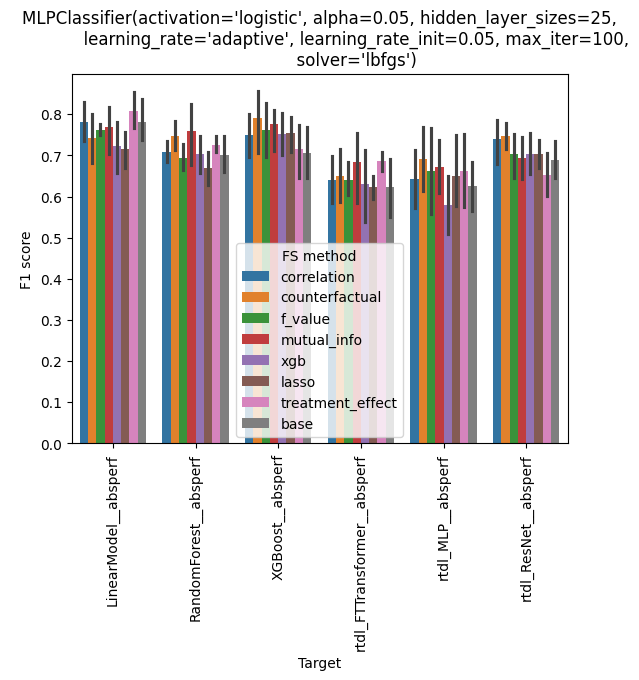

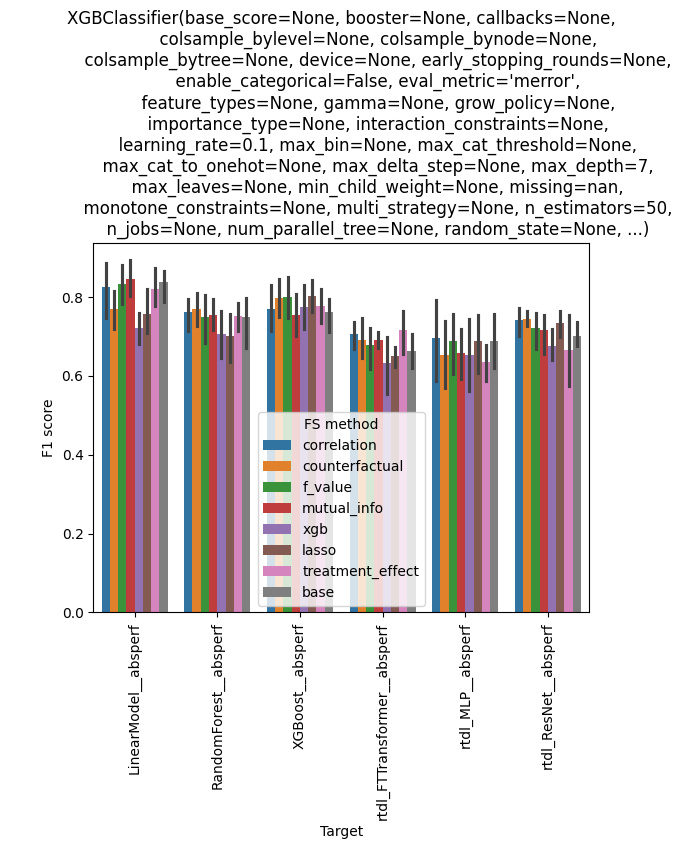

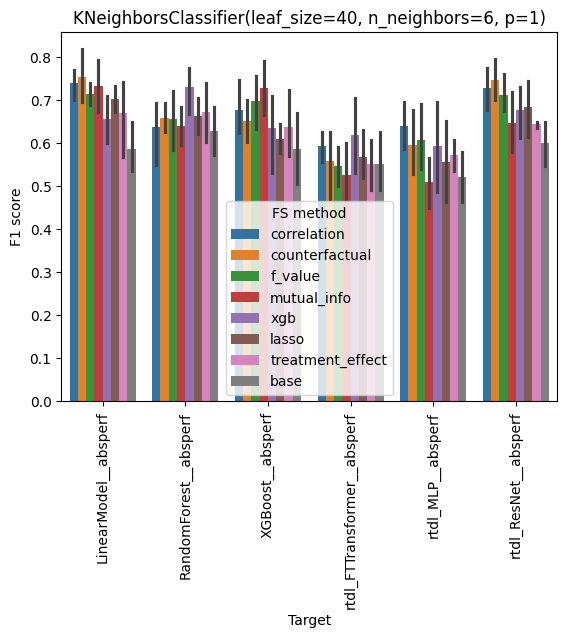

In [23]:
import seaborn as sns
for mtl in mtls:
    sample = result_df.loc[result_df['MtL'] == str(mtl)]
    plt.figure()
    plt.title(str(mtl))
    plt.xticks(rotation = 90)
    sns.barplot(x='Target', y='F1 score', hue='FS method', data=sample)
    

In [24]:
meta_models = [
MetaModel(
        name="mlp",
        display_name="MLP",
        model=MLPClassifier(),
        params={
            "hidden_layer_sizes": 25,
            "activation": "logistic",
            "solver": "lbfgs",
            "alpha": 0.05,
            "batch_size": "auto",
            "learning_rate": "adaptive",
            "learning_rate_init": 0.05,
            "max_iter": 100,
        },
),

MetaModel(
        name="xgb",
        display_name="XGBoost",
        model=XGBClassifier(),
        params={
            'max_depth': 7,
            'learning_rate': 0.1,
            'n_estimators': 50,
            "eval_metric": "merror",
        }
),

MetaModel(
        name="knn",
        display_name="KNN",
        model=KNeighborsClassifier(),
        params={
            "n_neighbors": 6,
            "weights": "uniform",
            "leaf_size": 40,
            "algorithm": "auto",
            "p": 1,
        }
)]

In [25]:
def mlp_importance_getter(estimator):
    # Sum absolute weights from input layer to first hidden layer
    return np.sum(np.abs(estimator.coefs_[0]), axis=1)

In [26]:
for m in models:
    print(m)
    y = targets[m].values
    for _ in range(5):
        print(_)
        X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3)
        for i, mtl in enumerate(mtls):
            if meta_models[i].name != 'knn':
                selector = RFESelector(md_source=None, model=mtl)
                if meta_models[i].name == 'mlp':
                    selector = RFESelector(md_source=None, model=mtl, importance_getter=mlp_importance_getter)
                df_res = selector.handle_data(X_train, y_train, init_features)
                df_res.dropna(inplace=True)
                selected_f = list(df_res.index)
                selected_f_index = [i for i, f in enumerate(init_features) if f in selected_f]

                X_train_selected = X_train[:,selected_f_index]
                X_test_selected = X_test[:, selected_f_index]
                model_selected = mtl
                model_selected.fit(X_train_selected, y_train)
                explainer_selected = get_explainer(model_selected, X_test_selected)
                shap_values_selected = compute_shap_values(explainer_selected, X_test_selected)
                selector_score = calculate_fraction(shap_values_selected, 5)
                f1_selected = f1_score(y_test, model_selected.predict(X_test_selected))
                df_dict = {'Target':[m], 'MtL':[str(mtl)], 'FS method':[selector.class_name], 'Importance fraction score':[selector_score], 'Selection number':[len(selected_f)], 'F1 score':[f1_selected]}
                result_df = pd.concat([result_df, pd.DataFrame.from_dict(df_dict)])
                print(result_df)


LinearModel__absperf
0


100%|██████████| 41/41 [00:19<00:00,  2.10it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

           FS method  Importance fraction score Sel

100%|██████████| 41/41 [00:18<00:00,  2.17it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:19<00:00,  2.16it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:19<00:00,  2.16it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:19<00:00,  2.15it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0        XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


                   Target                                                MtL  \
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0    LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0    LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0    LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                    ...                                                ...   
0   RandomForest__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   RandomForest__absperf  XGBClassifier(base_score=None, booster=None, c...   
0        XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0        XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0        XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction

100%|██████████| 41/41 [00:18<00:00,  2.18it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:19<00:00,  2.15it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:18<00:00,  2.20it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0       XGBoost__absperf  XGBClassifier(base_score=None, booster=None, c...   
0       XGBoost__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:18<00:00,  2.24it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0              XGBoost__absperf   
0              XGBoost__absperf   
0              XGBoost__absperf   
0              XGBoost__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   MLPClassifier(activation='logistic', alpha=0.0...             rf

100%|██████████| 41/41 [00:18<00:00,  2.25it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0              XGBoost__absperf   
0              XGBoost__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   MLPClassifier(activation='logistic', alpha=0.0...             rf

100%|██████████| 41/41 [00:18<00:00,  2.17it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   MLPClassifier(activation='logistic', alpha=0.0...             rf

100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   MLPClassifier(activation='logistic', alpha=0.0...             rf

100%|██████████| 41/41 [00:19<00:00,  2.15it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   MLPClassifier(activation='logistic', alpha=0.0...             rf

100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0             rtdl_MLP__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   MLPClassifier(activation='logistic', alpha=0.0...             rf

100%|██████████| 41/41 [00:19<00:00,  2.16it/s]


                         Target  \
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
0          LinearModel__absperf   
..                          ...   
0   rtdl_FTTransformer__absperf   
0   rtdl_FTTransformer__absperf   
0             rtdl_MLP__absperf   
0             rtdl_MLP__absperf   
0             rtdl_MLP__absperf   

                                                  MtL       FS method  \
0   MLPClassifier(activation='logistic', alpha=0.0...     correlation   
0   XGBClassifier(base_score=None, booster=None, c...     correlation   
0   KNeighborsClassifier(leaf_size=40, n_neighbors...     correlation   
0   MLPClassifier(activation='logistic', alpha=0.0...  counterfactual   
0   XGBClassifier(base_score=None, booster=None, c...  counterfactual   
..                                                ...             ...   
0   MLPClassifier(activation='logistic', alpha=0.0...             rf

100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:18<00:00,  2.17it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:18<00:00,  2.17it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0      rtdl_MLP__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0      rtdl_MLP__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:18<00:00,  2.18it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


                  Target                                                MtL  \
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   LinearModel__absperf  KNeighborsClassifier(leaf_size=40, n_neighbors...   
0   LinearModel__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   LinearModel__absperf  XGBClassifier(base_score=None, booster=None, c...   
..                   ...                                                ...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   
0   rtdl_ResNet__absperf  XGBClassifier(base_score=None, booster=None, c...   
0   rtdl_ResNet__absperf  MLPClassifier(activation='logistic', alpha=0.0...   

         FS method  Importance fraction score Selec

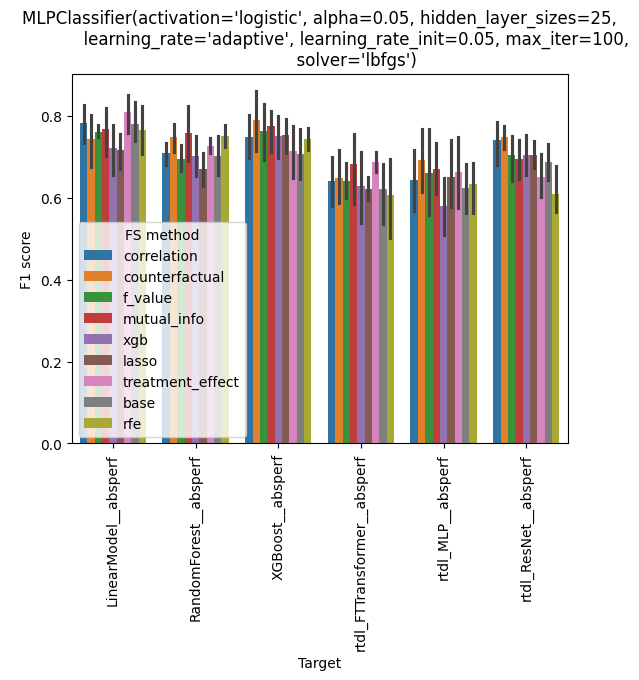

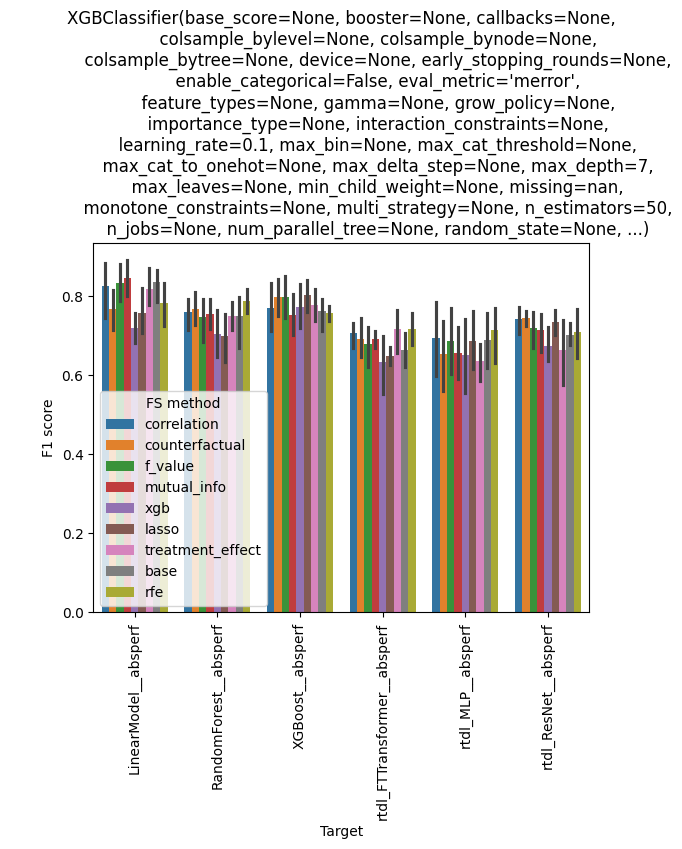

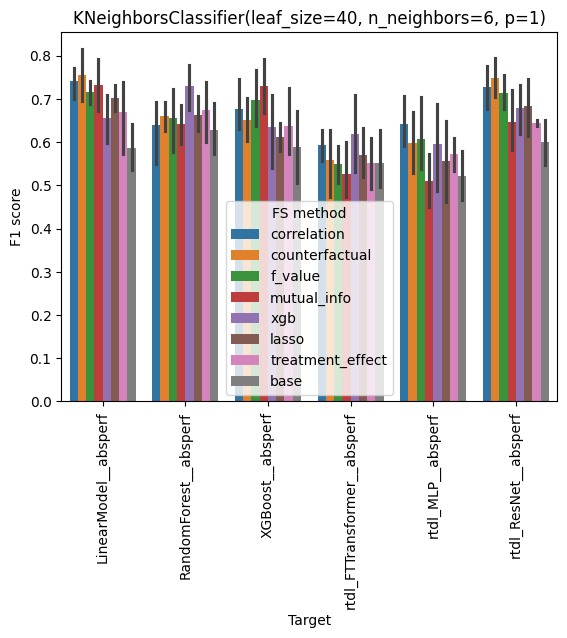

In [27]:
import seaborn as sns
for mtl in mtls:
    sample = result_df.loc[result_df['MtL'] == str(mtl)]
    plt.figure()
    plt.title(str(mtl))
    plt.xticks(rotation = 90)
    sns.barplot(x='Target', y='F1 score', hue='FS method', data=sample)
    

In [28]:
result_df.to_csv('interpret_f1_perf_abs_all.csv', index=False)

In [56]:
df = pd.read_csv('interpret_f1_perf_abs_all.csv')
df['Target'] = df['Target'].str.replace('__absperf', '', regex=False)
df

,Target,MtL,FS method,Importance fraction score,Selection number,F1 score
0,LinearModel,"MLPClassifier(activation='logistic', alpha=0.0...",correlation,0.348759,29,0.700000
1,LinearModel,"XGBClassifier(base_score=None, booster=None, c...",correlation,0.655539,29,0.684211
2,LinearModel,"KNeighborsClassifier(leaf_size=40, n_neighbors...",correlation,0.390277,29,0.736842
3,LinearModel,"MLPClassifier(activation='logistic', alpha=0.0...",counterfactual,0.499213,15,0.714286
4,LinearModel,"XGBClassifier(base_score=None, booster=None, c...",counterfactual,0.729883,15,0.742857
...,...,...,...,...,...,...
775,rtdl_ResNet,"XGBClassifier(base_score=None, booster=None, c...",rfe,0.549426,61,0.585366
776,rtdl_ResNet,"MLPClassifier(activation='logistic', alpha=0.0...",rfe,0.226028,61,0.611111
777,rtdl_ResNet,"XGBClassifier(base_score=None, booster=None, c...",rfe,0.461187,61,0.722222
778,rtdl_ResNet,"MLPClassifier(activation='logistic', alpha=0.0...",rfe,0.185612,61,0.562500


In [57]:
classic = ['LinearModel', 'RandomForest', 'XGBoost']
deep = ['rtdl_FTTransformer','rtdl_MLP', 'rtdl_ResNet']
df['Target type'] = np.where(df['Target'].isin(classic), 'Classic', 'Deep')
df

,Target,MtL,FS method,Importance fraction score,Selection number,F1 score,Target type
0,LinearModel,"MLPClassifier(activation='logistic', alpha=0.0...",correlation,0.348759,29,0.700000,Classic
1,LinearModel,"XGBClassifier(base_score=None, booster=None, c...",correlation,0.655539,29,0.684211,Classic
2,LinearModel,"KNeighborsClassifier(leaf_size=40, n_neighbors...",correlation,0.390277,29,0.736842,Classic
3,LinearModel,"MLPClassifier(activation='logistic', alpha=0.0...",counterfactual,0.499213,15,0.714286,Classic
4,LinearModel,"XGBClassifier(base_score=None, booster=None, c...",counterfactual,0.729883,15,0.742857,Classic
...,...,...,...,...,...,...,...
775,rtdl_ResNet,"XGBClassifier(base_score=None, booster=None, c...",rfe,0.549426,61,0.585366,Deep
776,rtdl_ResNet,"MLPClassifier(activation='logistic', alpha=0.0...",rfe,0.226028,61,0.611111,Deep
777,rtdl_ResNet,"XGBClassifier(base_score=None, booster=None, c...",rfe,0.461187,61,0.722222,Deep
778,rtdl_ResNet,"MLPClassifier(activation='logistic', alpha=0.0...",rfe,0.185612,61,0.562500,Deep


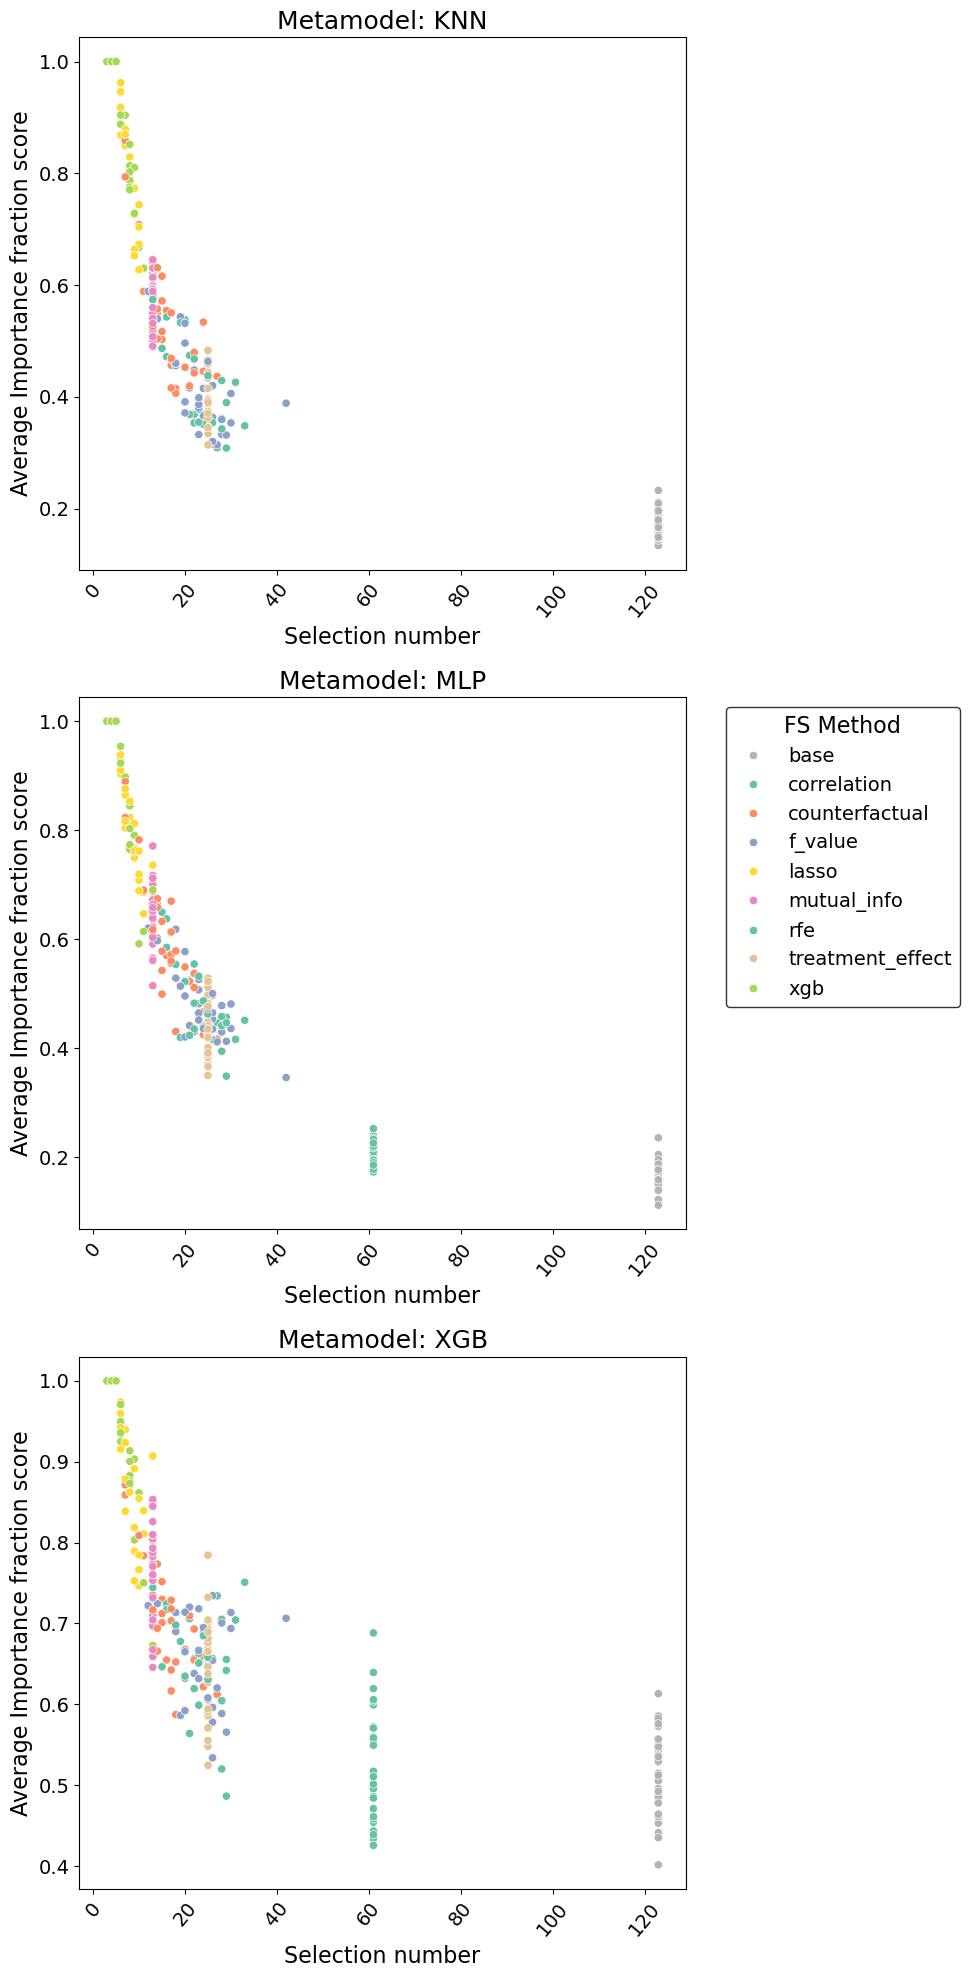

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Increase global font size
plt.rcParams.update({'font.size': 14})

# Preprocessing steps (unchanged)
df['Target'] = df['Target'].str.replace('__absperf', '', regex=False)

mtl_name_map = {
    'MLPClassifier': 'MLP',
    'XGBClassifier': 'XGB',
    'KNeighborsClassifier': 'KNN'
}
df['MtL_simple'] = df['MtL'].str.split('(').str[0].map(mtl_name_map)

# Create a consistent color palette for FS methods
fs_methods = df['FS method'].unique()
palette = sns.color_palette("Set2", len(fs_methods))
color_dict = {method: color for method, color in zip(fs_methods, palette)}

# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
mtl_labels = ['KNN', 'MLP', 'XGB']
top3_list = {}
for idx, (ax, mtl) in enumerate(zip(axes, mtl_labels)):
    data_sub = df[df['MtL_simple'] == mtl]
    current_fs = data_sub['FS method'].unique()
    current_fs_sorted = sorted(current_fs)  # Ensure consistent order

    # Create barplot with explicit hue_order
    sns.scatterplot(
        data=data_sub, 
        x='Selection number', 
        y='Importance fraction score', 
        hue='FS method', 
        palette=color_dict,
        hue_order=current_fs_sorted,
        # errorbar='sd',
        # err_kws={'linewidth': 1},
        # width=0.85,
        ax=ax
    )
    
    top3 = {}
    for target, group in data_sub.groupby('Target'):
        top_fs = group.groupby('FS method')['Importance fraction score'].mean().nlargest(3).index.tolist()
        top3[target] = top_fs

    top3_list[mtl] = top3


    # Customize subplot (unchanged)
    if idx in [0,2]:
        ax.get_legend().remove()
    else:
        legend = ax.legend(
            title='FS Method', 
            bbox_to_anchor=(1.05, 1), 
            loc='upper left', 
            fontsize=14, 
            title_fontsize=16,
            frameon=True
        )
        legend.get_frame().set_edgecolor('black')
    
    ax.set_title(f'Metamodel: {mtl}', fontsize=18)
    ax.set_xlabel('Selection number', fontsize=16)
    ax.set_ylabel('Average Importance fraction score', fontsize=16)
    ax.tick_params(axis='x', rotation=50)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
fig.savefig('interpret_all.png')
plt.show()


In [65]:
df

,Target,MtL,FS method,Importance fraction score,Selection number,F1 score,Target type,MtL_simple
0,LinearModel,"MLPClassifier(activation='logistic', alpha=0.0...",correlation,0.348759,29,0.700000,Classic,MLP
1,LinearModel,"XGBClassifier(base_score=None, booster=None, c...",correlation,0.655539,29,0.684211,Classic,XGB
2,LinearModel,"KNeighborsClassifier(leaf_size=40, n_neighbors...",correlation,0.390277,29,0.736842,Classic,KNN
3,LinearModel,"MLPClassifier(activation='logistic', alpha=0.0...",counterfactual,0.499213,15,0.714286,Classic,MLP
4,LinearModel,"XGBClassifier(base_score=None, booster=None, c...",counterfactual,0.729883,15,0.742857,Classic,XGB
...,...,...,...,...,...,...,...,...
775,rtdl_ResNet,"XGBClassifier(base_score=None, booster=None, c...",rfe,0.549426,61,0.585366,Deep,XGB
776,rtdl_ResNet,"MLPClassifier(activation='logistic', alpha=0.0...",rfe,0.226028,61,0.611111,Deep,MLP
777,rtdl_ResNet,"XGBClassifier(base_score=None, booster=None, c...",rfe,0.461187,61,0.722222,Deep,XGB
778,rtdl_ResNet,"MLPClassifier(activation='logistic', alpha=0.0...",rfe,0.185612,61,0.562500,Deep,MLP


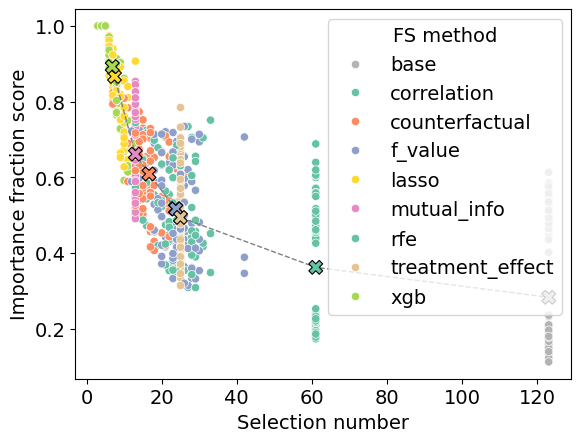

In [68]:
# Original scatterplot
sns.scatterplot(
    data=df, 
    x='Selection number', 
    y='Importance fraction score', 
    hue='FS method', 
    palette=color_dict,
    hue_order=current_fs_sorted,
)

# Calculate centroids
centroids = df.groupby('FS method', as_index=False).agg({
    'Selection number': 'mean',
    'Importance fraction score': 'mean'
})

# Sort centroids from top to bottom based on y-value
centroids_sorted = centroids.sort_values('Importance fraction score', ascending=False)

# Draw vertical connection line
plt.plot(
    centroids_sorted['Selection number'], 
    centroids_sorted['Importance fraction score'], 
    color='gray', linestyle='--', linewidth=1, zorder=1,
    marker='',  # No additional markers
)

# Plot centroids (keep original color coding)
sns.scatterplot(
    data=centroids,
    x='Selection number',
    y='Importance fraction score',
    hue='FS method',
    palette=color_dict,
    hue_order=current_fs_sorted,
    marker='X',
    s=100,
    edgecolor='black',
    legend=False,
    zorder=2
)

plt.show()

In [47]:
top3_list

{'KNN': {'LinearModel': ['counterfactual', 'correlation', 'mutual_info'],
  'RandomForest': ['xgb', 'treatment_effect', 'lasso'],
  'XGBoost': ['mutual_info', 'f_value', 'correlation'],
  'rtdl_FTTransformer': ['xgb', 'correlation', 'lasso'],
  'rtdl_MLP': ['correlation', 'f_value', 'counterfactual'],
  'rtdl_ResNet': ['counterfactual', 'correlation', 'f_value']},
 'MLP': {'LinearModel': ['treatment_effect', 'correlation', 'base'],
  'RandomForest': ['mutual_info', 'rfe', 'counterfactual'],
  'XGBoost': ['counterfactual', 'mutual_info', 'f_value'],
  'rtdl_FTTransformer': ['treatment_effect', 'mutual_info', 'counterfactual'],
  'rtdl_MLP': ['counterfactual', 'mutual_info', 'treatment_effect'],
  'rtdl_ResNet': ['counterfactual', 'correlation', 'f_value']},
 'XGB': {'LinearModel': ['mutual_info', 'base', 'f_value'],
  'RandomForest': ['rfe', 'counterfactual', 'correlation'],
  'XGBoost': ['lasso', 'f_value', 'counterfactual'],
  'rtdl_FTTransformer': ['rfe', 'treatment_effect', 'correla

In [ ]:
for m in fs_methods:
    count = 0
    for el in top3_list:
        for t in el:
            if f in el[t]:
                count += 1
    print(f)
    print((count / 18) * 100)

correlation
61.111111111111114
counterfactual
61.111111111111114
f_value
38.88888888888889
mutual_info
38.88888888888889
xgb
11.11111111111111
lasso
22.22222222222222
treatment_effect
27.77777777777778
base
16.666666666666664
rfe
22.22222222222222


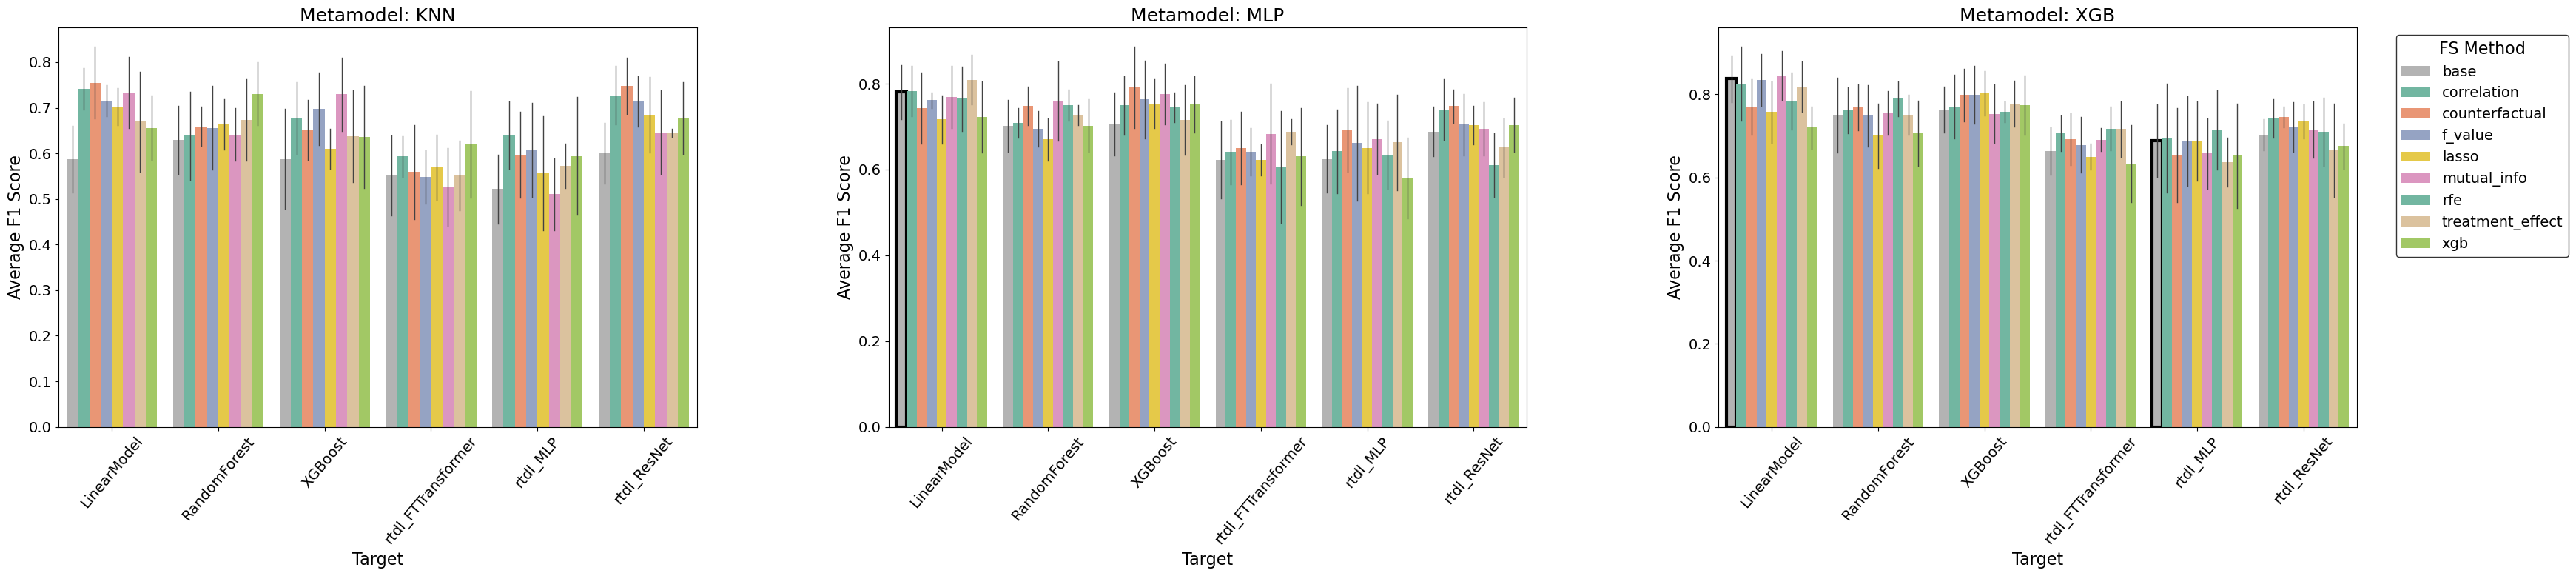

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Increase global font size
plt.rcParams.update({'font.size': 14})

# Preprocessing steps (unchanged)
df['Target'] = df['Target'].str.replace('__absperf', '', regex=False)

mtl_name_map = {
    'MLPClassifier': 'MLP',
    'XGBClassifier': 'XGB',
    'KNeighborsClassifier': 'KNN'
}
df['MtL_simple'] = df['MtL'].str.split('(').str[0].map(mtl_name_map)

# Create a consistent color palette for FS methods
fs_methods = df['FS method'].unique()
palette = sns.color_palette("Set2", len(fs_methods))
color_dict = {method: color for method, color in zip(fs_methods, palette)}

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(35, 8))
mtl_labels = ['KNN', 'MLP', 'XGB']

# Helper function: given a patch’s facecolor, determine its FS method from our color_dict.
def get_fs_from_color(color):
    # color is an RGBA tuple; compare only the first three (RGB)
    for fs, col in color_dict.items():
        if np.allclose(color[:3], col):
            return fs
    return None

for idx, (ax, mtl) in enumerate(zip(axes, mtl_labels)):
    data_sub = df[df['MtL_simple'] == mtl]
    current_fs = data_sub['FS method'].unique()
    current_fs_sorted = sorted(current_fs)  # Ensure consistent order

    # Create barplot with explicit hue_order
    sns.barplot(
        data=data_sub, 
        x='Target', 
        y='F1 score', 
        hue='FS method', 
        palette=color_dict,
        hue_order=current_fs_sorted,
        errorbar='sd',
        err_kws={'linewidth': 1},
        width=0.85,
        ax=ax
    )
    # Remove legend from the first two plots; add it on the last
    if idx < 2:
        ax.get_legend().remove()
    else:
        legend = ax.legend(
            title='FS Method', 
            bbox_to_anchor=(1.05, 1), 
            loc='upper left', 
            fontsize=14, 
            title_fontsize=16,
            frameon=True
        )
        legend.get_frame().set_edgecolor('black')
    
    ax.set_title(f'Metamodel: {mtl}', fontsize=18)
    ax.set_xlabel('Target', fontsize=16)
    ax.set_ylabel('Average F1 Score', fontsize=16)
    ax.tick_params(axis='x', rotation=50)
    
    # --- Determine the top three FS methods per Target ---
    # Compute the average F1 score for each (Target, FS method) pair.
    group_means = data_sub.groupby(['Target', 'FS method'])['F1 score'].mean().reset_index()
    top3_dict = {}
    for target in group_means['Target'].unique():
        subset = group_means[group_means['Target'] == target]
        top3_methods = subset.nlargest(3, 'F1 score')['FS method'].tolist()
        top3_dict[target] = top3_methods

    # --- Highlight bars that belong to the top three FS methods ---
    # Get x-axis tick positions and corresponding labels (which are the Targets).
    ticks = np.array(ax.get_xticks())  # convert to NumPy array for arithmetic
    tick_labels = [label.get_text() for label in ax.get_xticklabels()]

    # Loop over each bar (patch)
    for patch in ax.patches:
        # Determine the center x coordinate of the bar.
        center = patch.get_x() + patch.get_width()/2
        # Find the tick (i.e. Target group) nearest to this center.
        tick_index = np.argmin(np.abs(ticks - center))
        target_label = tick_labels[tick_index]
        
        # Infer the FS method based on the patch’s facecolor.
        fs_method = get_fs_from_color(patch.get_facecolor())
        
        # If this FS method is among the top three for the given Target, highlight it.
        if fs_method is not None and fs_method in top3_dict.get(target_label, []):
            patch.set_edgecolor('black')
            patch.set_linewidth(3)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()
